![Intro](Intro.png)

In [1]:
#Importing the necessary libraries and ignore warnings 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from landlab.components import (
    SpaceLargeScaleEroder, PriorityFloodFlowRouter,
    DepthDependentDiffuser, ExponentialWeatherer, 
    BedrockLandslider, ChannelProfiler
)
from landlab import RasterModelGrid, imshowhs_grid, imshow_grid
from auxiliary_functions import (get_topo, smooth_elevation_grid) 
import warnings
from tqdm import tqdm 

warnings.filterwarnings('ignore') # ignore warning when running the code

![Topo](Topo2.png)

In [2]:
"""
Importing topography from OpenTopography using bmi_topography, smoothing the elevation to 
get rid of artifacts and defining the topographic__elevation field. 
"""
dem_info = {
        'dem_type': "SRTMGL3",
        'north': 5.9454,
        'east': -75.8607,
        'south': 5.5595,
        'west': -76.2852,
        'buffer': 0.01,
        'smooth_num': 2
        }
grid, z = get_topo(dem_type=dem_info['dem_type'],
                north=dem_info['north'],south=dem_info['south'],
                east=dem_info['east'],west=dem_info['west'],
                buffer=dem_info['buffer']) # Smoothen downloaded DEM
# Smooth topography to get rid of small anomalies
smoothed_elev = smooth_elevation_grid(grid, method='gaussian', smooth_num=4) #function to smooth elevation
# Update original topography with the smoothed result
grid.at_node["topographic__elevation"] = smoothed_elev #defining the topographic__elevation field from the smoothed_elev

# %%% Add required fields to the grid
soil_depth = grid.add_zeros("node", "soil__depth", clobber=True)

# Set 2 m of initial soil depth at core nodes
grid.at_node["soil__depth"][grid.core_nodes] = 2.0  # meters

# Add field 'bedrock__elevation' to the grid
b = grid.add_zeros("bedrock__elevation", at="node", clobber=True)

# Sum 'soil__depth' and 'bedrock__elevation' to yield 'topographic elevation'
grid.at_node["bedrock__elevation"][:] = grid.at_node["topographic__elevation"]
grid.at_node["topographic__elevation"][:] += grid.at_node["soil__depth"]

grid.at_node["bedrock__elevation"]= grid.at_node["topographic__elevation"] - grid.at_node["soil__depth"]

{'dem_type': 'SRTMGL3', 'south': 5.5495, 'north': 5.9554, 'west': -76.29520000000001, 'east': -75.85069999999999, 'output_format': 'AAIGrid', 'cache_dir': PosixPath('/home/jupyter-m.wanderleydealmei-5aef5/ivy'), 'api_key': 'f08b2664772eb044626d5cb114924de1'}
<xarray.DataArray 'SRTMGL3' (band: 1, y: 487, x: 533)> Size: 1MB
[259571 values with dtype=int32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 4kB -76.3 -76.29 -76.29 ... -75.85 -75.85 -75.85
  * y            (y) float64 4kB 5.955 5.954 5.953 5.952 ... 5.552 5.551 5.55
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:    0
    scale_factor:  1.0
    add_offset:    0.0
    units:         unknown


## Calculate slopes

In [3]:
slopes = grid.calc_slope_at_node(elevs='topographic__elevation')
slopes_degrees = np.degrees(slopes) # Convert slopes to degrees from radians

slopes_mean = np.nanmean(slopes_degrees)
slopes_std = np.nanstd(slopes_degrees)

slopes_m2sig = slopes_mean - (2 * slopes_std)
slopes_p2sig = slopes_mean + (2 * slopes_std)

counts, bins_slopes = np.histogram(slopes_degrees, 100)

## Plot slope distribution

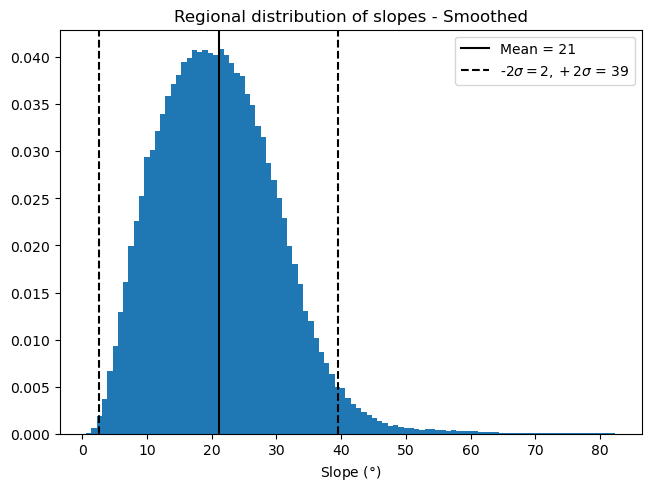

In [4]:
# Plot slope distribution
fig_slopes, ax_slopes = plt.subplots(layout="constrained")

plt.hist(slopes_degrees, bins=bins_slopes, density=True)
plt.axvline(x=slopes_mean,
            color="black", label="Mean = %.2d" % slopes_mean)
plt.axvline(x=slopes_m2sig,
            color='black', linestyle='--',
            label='-2$\\sigma = %d, +2\\sigma$ = %d' % (slopes_m2sig, slopes_p2sig))
plt.axvline(x=slopes_p2sig,
            color='black', linestyle='--',)

plt.legend()
ax_slopes.set_xlabel(r'Slope ($\degree$)')
ax_slopes.set_title('Regional distribution of slopes - Smoothed')

plt.show()

![Components](ComponentsV2.png)

# Define parameters for components

In [5]:
model_Params = {
    #Uplift
    'uplift' : 0.001,
    
    #Space parameters
    'K_sed' : 5e-5, 
    'K_br' : 5e-5,
    'F_f' : 0,
    'H_star' : 1,
    'phi' : 0.3,
    'v_s' : 1,
    'v_s_lake' : 1,
    'm_sp' : 0.5,
    'n_sp' : 1, 
    'sp_crit_sed' : 0,
    'sp_crit_br' : 0,
    
    # DepthDependentDiffuser parameters
    'linear_diffusivity' : 0.01,
    'soil_transport_decay_depth' : 1.0,

    # BedrockLandslider parameters
    'angle_int_frict' : np.radians(30),
    'cohesion_eff' : np.ones_like(z) * 1e3, # Pa
    'landslides_return_time' : 100,

    # Time parameters
    'dt' : 100, # timestep (yrs)
    'total_time' : 2000, # total runtime (yrs)
}

# Study Area: Northern Andes

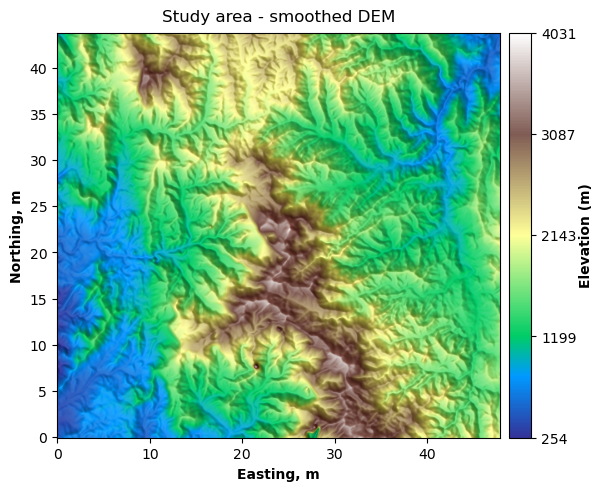

In [6]:
# Plot the imported DEM
fig_DEM = plt.figure(layout='constrained')

imshowhs_grid(grid, 'topographic__elevation', var_name='Elevation',
              var_units='m', 
              ticks_km=True,
              cmap="terrain",
              cbar_or="vertical",
              cbar_width="5%",
              cbar_height="100%",
              bbox_to_anchor=(0.07, 0, 1, 1),
              colorbar_label_y=2)

fig = plt.gcf()  # Get the current figure
cbar = fig.axes[-1]  # Last axis is usually the colorbar
tick_values = np.linspace(np.nanmin(grid.at_node["topographic__elevation"]),
                          np.nanmax(grid.at_node["topographic__elevation"]),
                          num=5)
cbar.set_yticks(tick_values)
cbar.set_yticklabels([f"{v:.0f}" for v in tick_values])

plt.suptitle('Study area - smoothed DEM')
plt.show()

## Initialize required components

![Model3](Model3.png)

In [7]:
# 1. Flow router
pf = PriorityFloodFlowRouter(grid, surface="topographic__elevation",
                             flow_metric="D8", hill_flow_metric="Quinn", depression_handler="fill",
                             update_hill_flow_instantaneous=True, update_flow_depressions=True,
                             update_hill_depressions=True, accumulate_flow=True,
                             accumulate_flow_hill=True, separate_hill_flow=True,
                             suppress_out=True
                             )
pf.run_one_step()

# 2. SPACE erosion
sp = SpaceLargeScaleEroder(grid, K_sed=model_Params['K_sed'], K_br=model_Params['K_br'], F_f=model_Params['F_f'],
                           phi=model_Params['phi'], H_star=model_Params['H_star'], v_s=model_Params['v_s'],
                           v_s_lake=model_Params['v_s_lake'], m_sp=model_Params['m_sp'], n_sp=model_Params['n_sp'],
                           sp_crit_sed=model_Params['sp_crit_sed'], sp_crit_br=model_Params['sp_crit_br'],
                           )

# 3. Soil production
ew = ExponentialWeatherer(grid, soil_production_decay_depth=1.0,
                          soil_production_maximum_rate=1.0
                         )

# 4. Soil diffusion
DDD = DepthDependentDiffuser(grid, linear_diffusivity=model_Params['linear_diffusivity'],
                             soil_transport_decay_depth=model_Params['soil_transport_decay_depth']
                            )

# 5. Bedrock landslider
ls = BedrockLandslider(grid, angle_int_frict=model_Params['angle_int_frict'], cohesion_eff=model_Params['cohesion_eff'],
                       landslides_return_time=model_Params['landslides_return_time'], verbose_landslides=False, landslides_on_boundary_nodes=False,
                      )


In [8]:
"""
Initializing arrays to save outputs
"""
i = 0
# Initialise soil depth output arrays
soil_depth_max = []
soil_depth_min = []
soil_depth_avg = []

# Initialise landslide output arrays
landslides_sizes_ret = []
landslides_volumes_ret = []

ero_cumul = grid.add_zeros("ero_cumul", at="node", clobber=True)
depo_cumul = grid.add_zeros("depo_cumul", at="node", clobber=True)

# Store premodel elevations
z_before_LS = np.array(grid["node"]["topographic__elevation"])
soilD_before_LS = np.array(grid["node"]["soil__depth"])
bedrock_before_LS = np.array(grid["node"]["bedrock__elevation"])

HyLands_landslides_size = []
HyLands_landslides_volume = []
HyLands_landslides_volume_sed = None
HyLands_landslides_volume_bed = None

![Profile](Profile.png)

(0.0, 3617.7075681010224)

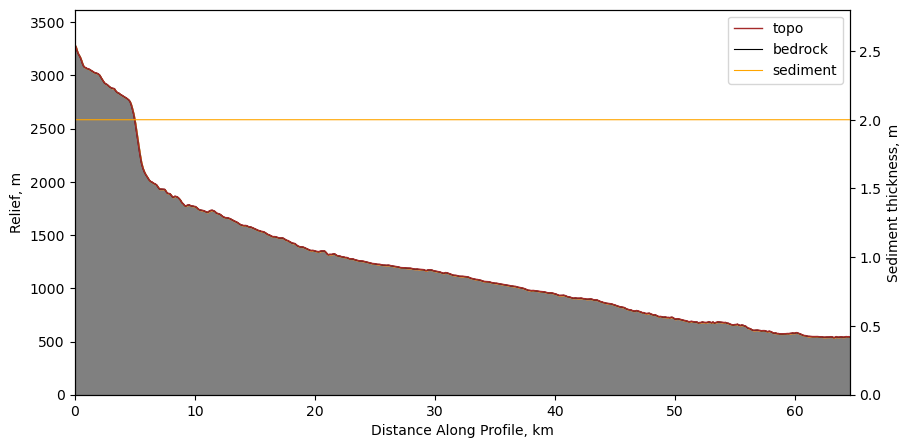

In [9]:
"""
Running ChannelProfiler to plot the longitudinal profile of the river, showing colluvial thickness and bedrock elevation
"""

profiler = ChannelProfiler(grid)

profiler.run_one_step()

fig, ax1 = plt.subplots(figsize=(10,5))
riv_nodes = profiler.nodes
grid.at_node["bedrock_elevation"]=grid.at_node["topographic__elevation"]-grid.at_node["soil__depth"]

dist_atNodes=profiler.distance_along_profile[0]

el = grid.at_node["topographic__elevation"][riv_nodes]
sd = grid.at_node["soil__depth"][riv_nodes]
br = el-sd

# Use ravel() to flatten el and br to 1D

el = el.ravel()
sd = sd.ravel()
br = br.ravel()

# Calculate minimum elevation and relief
min_elevation = min(np.min(el), np.min(br), 0)
el_relief = el - min_elevation
br_relief = br - min_elevation

qs = grid.at_node["sediment__flux"][riv_nodes]
qs[np.where(qs<10)] = np.nan

plt_fontsize =10

#fig, ax1 = plt.subplots(figsize=(5,3.7), dpi=400)
ax2 = ax1.twinx()
dist = (max(dist_atNodes)-dist_atNodes)*1e-3

brown_c = [205/255,133/255,63/255] #Choosing the color for the colluvial material 

# Fill the bedrock and colluvial material relief
ax1.fill_between(dist, br_relief, 0, color='grey', label='bedrock')
ax1.fill_between(dist, el_relief, br_relief, color=brown_c, label='colluvial material')        


# Plot bedrock and topographic relief
lns2 = ax1.plot(dist, br_relief, color='k', label='bedrock', linewidth=0.8, zorder=3)
lns1 = ax1.plot(dist, el_relief, color='brown', label='topo', linewidth=1, zorder=4)

# set up labels
ax1.set_xlabel('Distance Along Profile, km', fontweight='normal', fontsize=plt_fontsize)
ax1.tick_params(labelsize=plt_fontsize)
ax1.set_ylabel('Relief, m', fontweight='normal', fontsize=plt_fontsize)
ax1.set_ylim((0, np.max(el_relief)*1.1))


# plot sediment thickness
lns3 = ax2.plot(dist, sd, color='orange', label ='sediment', linewidth=0.8)

ax2.set_ylabel('Sediment thickness, m', fontweight='normal', fontsize=plt_fontsize)
ax2.set_ylim((0, np.nanmax(sd) * 1.4))
ax2.set_xlim((0, dist[2]))
ax2.tick_params(labelsize=plt_fontsize)

# Merge legends
lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=plt_fontsize)


# Set y-axis to start from 0
ax1.set_ylim(bottom=0)

![Results](Results.png)

![Cohesion](Cohesion.png)

In [10]:
# Store initial grid state
z_before_LS = grid.at_node["topographic__elevation"].copy()
soilD_before_LS = grid.at_node["soil__depth"].copy()
bedrock_before_LS = grid.at_node["bedrock__elevation"].copy()

# Define cohesion values to test
cohesion_values = [1000, 10000, 25000]  
results = {}

for cohesion in cohesion_values:
    # Reset grid to initial state
    grid.at_node["topographic__elevation"][:] = z_before_LS
    grid.at_node["soil__depth"][:] = soilD_before_LS
    grid.at_node["bedrock__elevation"][:] = bedrock_before_LS
    
    # Update cohesion in model parameters
    model_Params['cohesion_eff'] = np.ones_like(z) * cohesion
    
    # Reinitialize components with current parameters
    pf = PriorityFloodFlowRouter(grid, surface="topographic__elevation",
                                 flow_metric="D8", hill_flow_metric="Quinn", depression_handler="fill",
                                 update_hill_flow_instantaneous=True, update_flow_depressions=True,
                                 update_hill_depressions=True, accumulate_flow=True,
                                 accumulate_flow_hill=True, separate_hill_flow=True,
                                 suppress_out=True)
    sp = SpaceLargeScaleEroder(grid, K_sed=model_Params['K_sed'], K_br=model_Params['K_br'], F_f=model_Params['F_f'],
                               phi=model_Params['phi'], H_star=model_Params['H_star'], v_s=model_Params['v_s'],
                               v_s_lake=model_Params['v_s_lake'], m_sp=model_Params['m_sp'], n_sp=model_Params['n_sp'],
                               sp_crit_sed=model_Params['sp_crit_sed'], sp_crit_br=model_Params['sp_crit_br'])
    ew = ExponentialWeatherer(grid, soil_production_decay_depth=1.0,
                              soil_production_maximum_rate=1.0)
    DDD = DepthDependentDiffuser(grid, linear_diffusivity=model_Params['linear_diffusivity'],
                                 soil_transport_decay_depth=model_Params['soil_transport_decay_depth'])
    ls = BedrockLandslider(grid, angle_int_frict=model_Params['angle_int_frict'], 
                           cohesion_eff=model_Params['cohesion_eff'],
                           landslides_return_time=model_Params['landslides_return_time'], 
                           verbose_landslides=False, landslides_on_boundary_nodes=False)
    
    # Initialize variables for this run
    time_series_areas = []
    all_landslide_areas = []  # To collect individual landslide areas
    cell_area = grid.dx ** 2
    n_dt = int(model_Params['total_time'] / model_Params['dt'])
    timesteps = np.arange(0, model_Params['total_time'], model_Params['dt'])
    ero_cumul = grid.add_zeros("ero_cumul", at="node", clobber=True)
    depo_cumul = grid.add_zeros("depo_cumul", at="node", clobber=True)
    
    # Run the model
    pbar = tqdm(range(n_dt), desc=f'Cohesion {cohesion} Pa')
    for i in pbar:
        pf.run_one_step()
        sp.run_one_step(model_Params['dt'])
        ls.run_one_step(model_Params['dt'])
        ew.run_one_step()
        DDD.run_one_step(model_Params['dt'])
        
        # Record individual landslide areas
        if len(ls.landslides_size) > 0:
            areas = [size * cell_area for size in ls.landslides_size]
            all_landslide_areas.extend(areas)
            total_area = sum(ls.landslides_size) * cell_area
        else:
            total_area = 0.0
        time_series_areas.append(total_area)
        
        # Apply uplift
        grid.at_node["bedrock__elevation"][:] += model_Params['uplift'] * model_Params['dt']
        # Update topographic elevation to maintain consistency
        grid.at_node["topographic__elevation"][:] = (
            grid.at_node["bedrock__elevation"] + grid.at_node["soil__depth"]
        )
    
    # Run ChannelProfiler after model run
    profiler = ChannelProfiler(grid)
    profiler.run_one_step()
    riv_nodes = profiler.nodes[0]
    
    # Collect profile data
    dist_atNodes = profiler.distance_along_profile[0]
    el = grid.at_node["topographic__elevation"][riv_nodes]
    sd = grid.at_node["soil__depth"][riv_nodes]
    br = grid.at_node["bedrock__elevation"][riv_nodes]


    # Store results
    results[cohesion] = {
        'timesteps': timesteps,
        'areas': time_series_areas,
        'all_landslide_areas': all_landslide_areas,
        'profile': {
            'dist_atNodes': dist_atNodes,
            'el': el,
            'sd': sd,
            'br': br
        }
    }
    

Cohesion 25000 Pa: 100%|██████████| 20/20 [01:38<00:00,  4.94s/it]


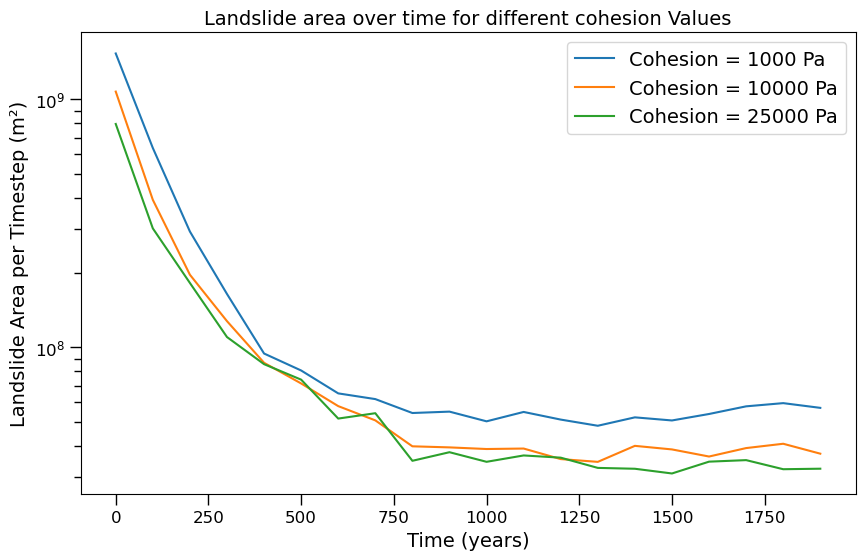

In [11]:
# Plotting
plt.figure(figsize=(10, 6))
for cohesion in cohesion_values:
    data = results[cohesion]
    plt.plot(data['timesteps'], data['areas'], label=f'Cohesion = {cohesion} Pa')
plt.xlabel('Time (years)', fontsize =14)
plt.ylabel('Landslide Area per Timestep (m²)', fontsize =14)
plt.yscale("log")
plt.legend(fontsize =14)
plt.tick_params(axis='both', which='major', length=8, width=1, labelsize=12)
plt.tick_params(axis='both', which='minor', length=5, width=1, labelsize=12)
plt.title('Landslide area over time for different cohesion Values', fontsize =14)
plt.show()

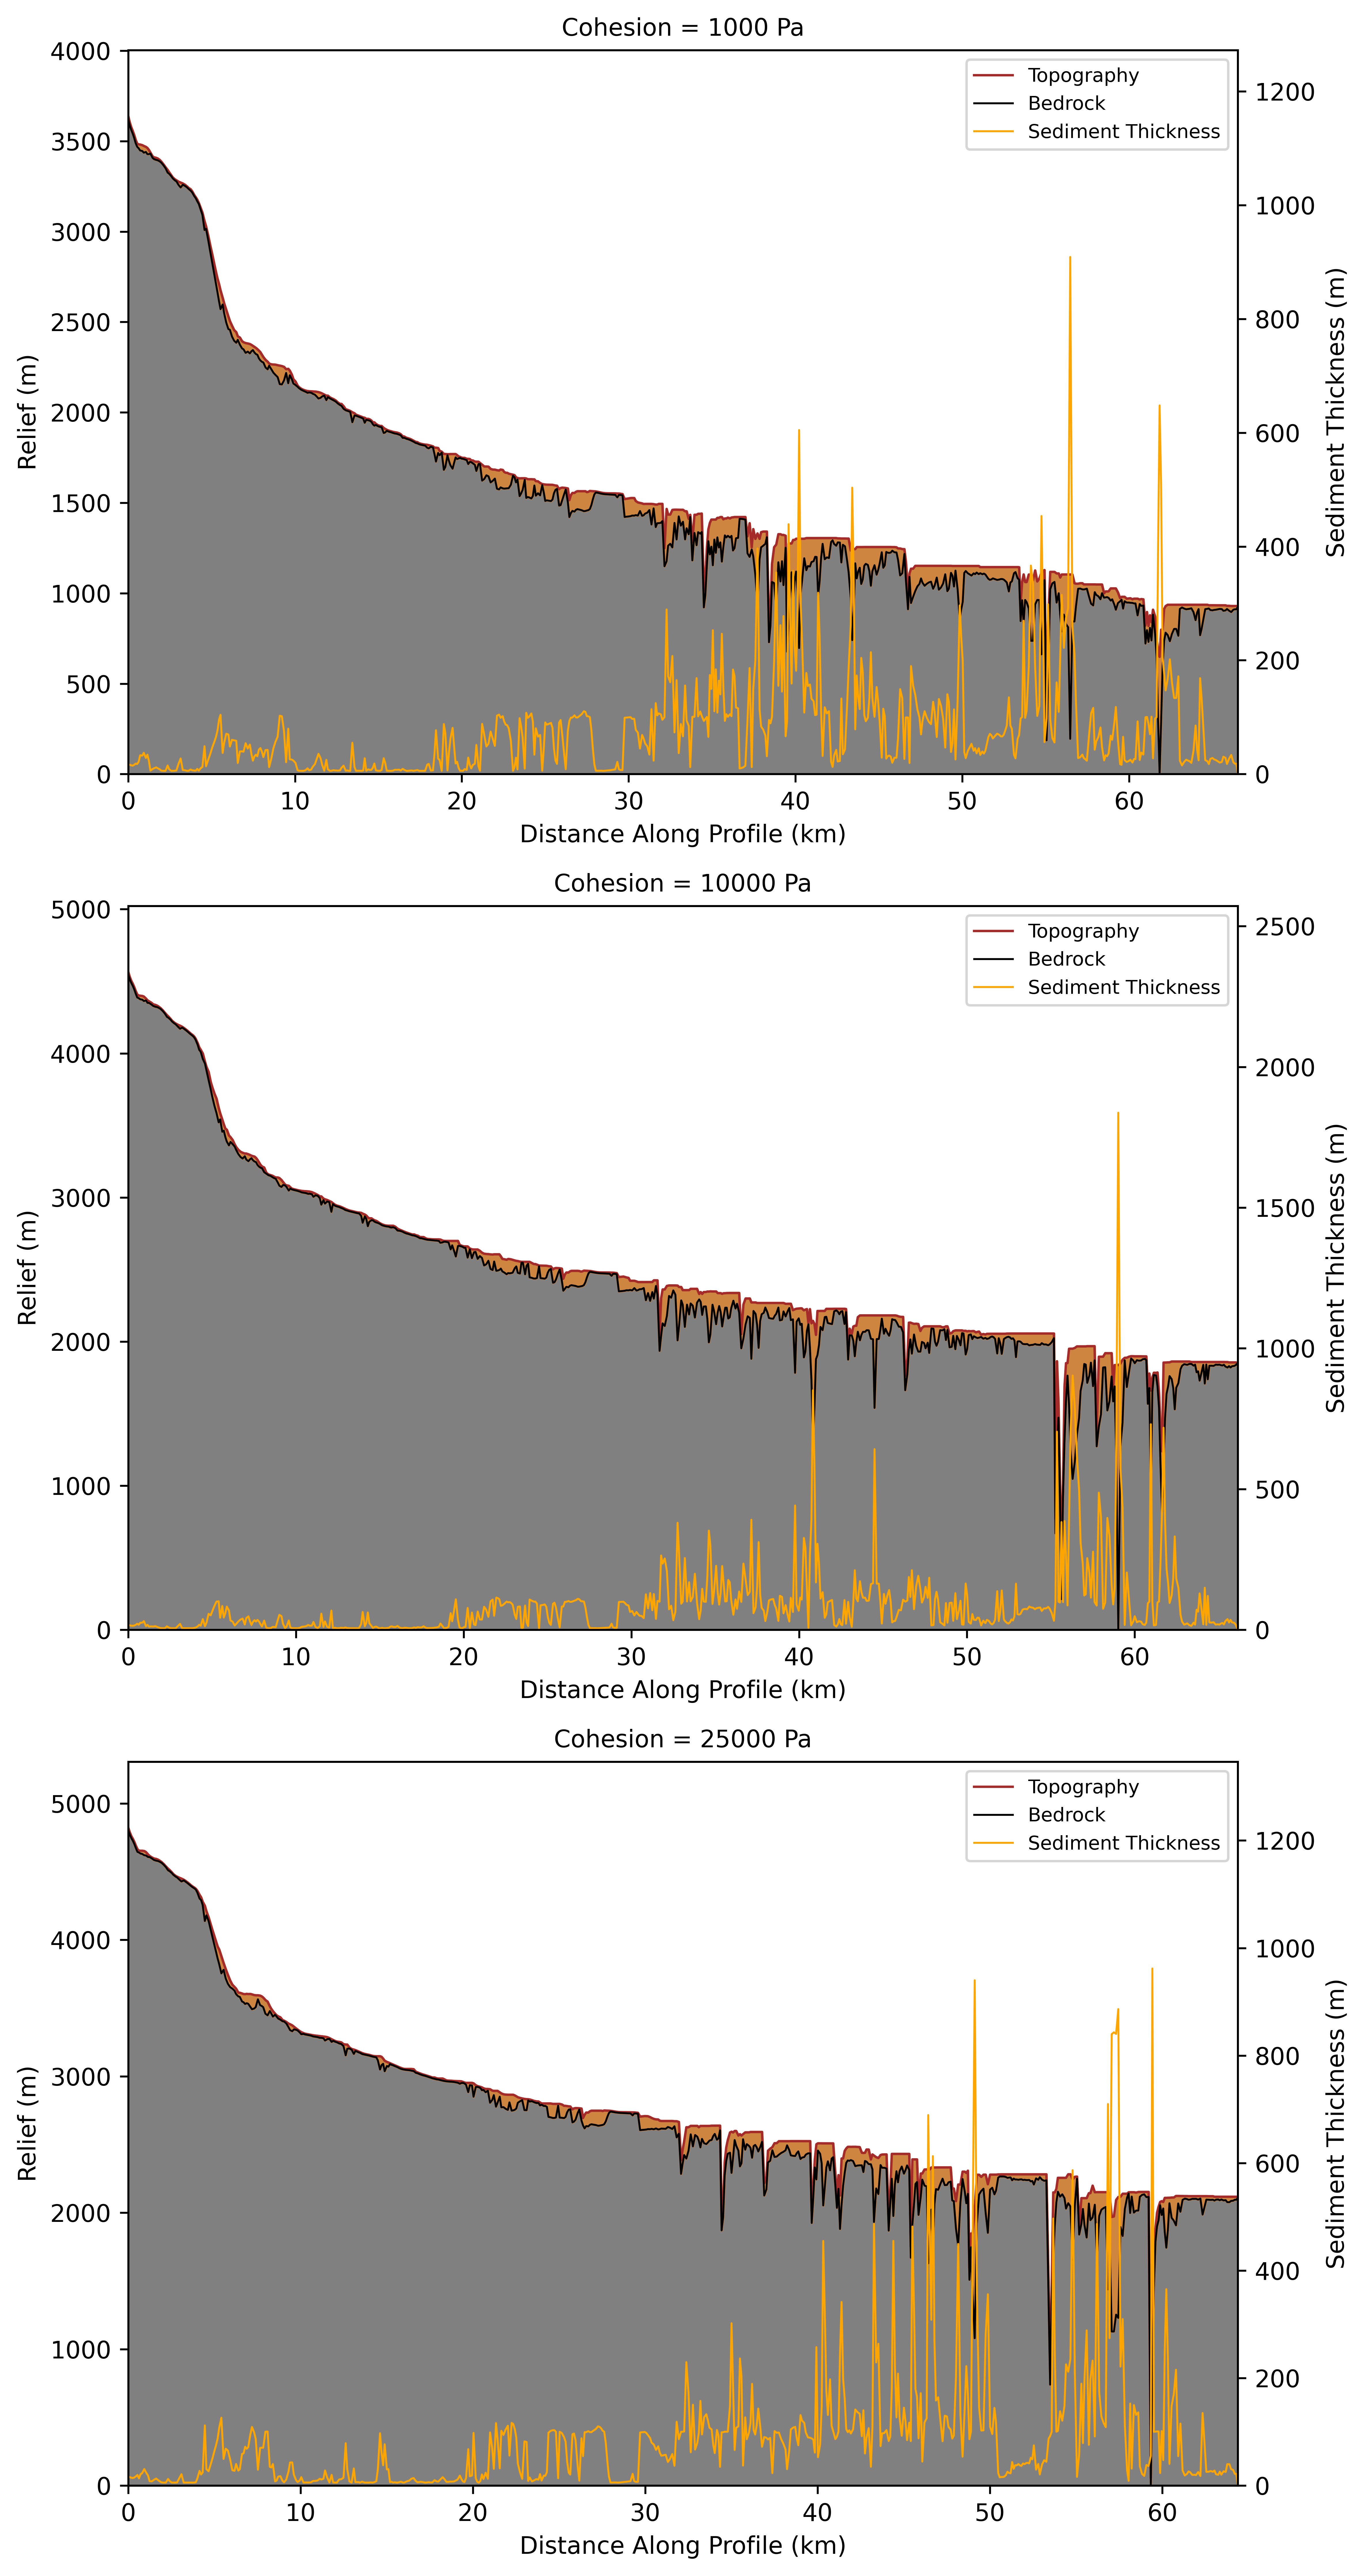

In [12]:
# Plot channel profiles for each cohesion
plt_fontsize = 10
brown_c = [205/255, 133/255, 63/255]

fig, axes = plt.subplots(3, 1, figsize=(8, 15), dpi=600)

for i, cohesion in enumerate(cohesion_values):
    ax1 = axes[i]
    profile_data = results[cohesion]['profile']
    
    dist = (np.max(profile_data['dist_atNodes']) - profile_data['dist_atNodes']) * 1e-3
    el = profile_data['el'].ravel()
    sd = profile_data['sd'].ravel()
    br = profile_data['br'].ravel()
    
    min_elevation = min(np.min(el), np.min(br), 0)
    el_relief = el - min_elevation
    br_relief = br - min_elevation
    
    ax2 = ax1.twinx()
    
    # Fill bedrock and colluvial material
    ax1.fill_between(dist, br_relief, 0, color='grey', label='Bedrock')
    ax1.fill_between(dist, el_relief, br_relief, color=brown_c, label='Colluvial Material')
    
    # Plot elevation profiles
    lns1 = ax1.plot(dist, el_relief, color='brown', linewidth=1, label='Topography')
    lns2 = ax1.plot(dist, br_relief, color='k', linewidth=0.8, label='Bedrock')
    
    # Plot sediment thickness
    lns3 = ax2.plot(dist, sd, color='orange', linewidth=0.8, label='Sediment Thickness')
    
    # Configure axes
    ax1.set_xlabel('Distance Along Profile (km)', fontsize=plt_fontsize)
    ax1.set_ylabel('Relief (m)', fontsize=plt_fontsize)
    ax2.set_ylabel('Sediment Thickness (m)', fontsize=plt_fontsize)
    ax1.set_ylim(0, np.max(el_relief)*1.1)
    ax2.set_ylim(0, np.nanmax(sd)*1.4)
    ax1.set_xlim(0, np.max(dist))
    ax1.tick_params(labelsize=plt_fontsize)
    ax2.tick_params(labelsize=plt_fontsize)
    ax1.set_title(f'Cohesion = {cohesion} Pa', fontsize=plt_fontsize)
    
    # Combine legends
    lns = lns1 + lns2 + lns3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='upper right', fontsize=plt_fontsize-2)

plt.tight_layout()
plt.show()

![Discusion](Discusion.png)